# Investigateing high-frequency sinusoidal noise

In the principal component analysis of NIRCam short-wave photometry of 55 Cnc e, we see a high frequency sinusoidal noise. The main frequency of the oscillation is ~3.3-3.4 minutes. Although this doesn't really affect the aperture photometry data, we want to find the origin of this noise. We manually looked into many telemetry timeseries data to see if any of the data show a similar high-frequency noise. We find that one parameter with mnemonic "SA_ZADUCMDX" show a similar high-frequency noise. This parameter have the information of "ADU Commanded FSM Angle (on the sky) - X axis". The Y-axis component of the same parameter also shows the same noise, but it's not that prominent.

In this notebook, we will investigate if this data has the same noise as the 4th PC of short-wave photometry data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from astropy.timeseries import LombScargle
from astropy import units as u
from astropy.stats import mad_std

In [2]:
visit = 'NRCSW'

p1 = '/'.join(os.getcwd().split('/')[:-1])

# Loading PCs
pcs = np.load(p1 + '/NRCSW/Outputs/' + visit + '/PCs.npy')
pc4 = pcs[17,:]

# Loading the time of the observations
tim = np.loadtxt(p1 + '/NRCSW/Outputs/' + visit + '/Photometry_' + visit + '_photutils.dat', usecols=0, unpack=True)
tim = tim + 2400000.5

# Loading the telemetry parameter SA_ZADUCMDX
fsax = glob(p1 + '/Telemetry/Data/' + visit + '/SA_ZADUCMDX*')[0]
sa1x = np.genfromtxt(fsax, delimiter=',')
tim_sax, val_sax = sa1x[1:,1], sa1x[1:,2]
tim_sax = tim_sax + 2400000.5

# Loading the telemetry parameter SA_ZADUCMDY
fsay = glob(p1 + '/Telemetry/Data/' + visit + '/SA_ZADUCMDY*')[0]
sa1y = np.genfromtxt(fsay, delimiter=',')
tim_say, val_say = sa1y[1:,1], sa1y[1:,2]
tim_say = tim_say + 2400000.5

Now, let's plot both variables on the same plot,

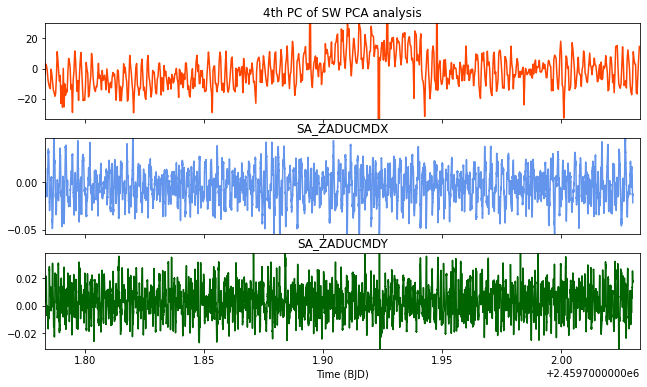

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(16/1.5, 9/1.5), sharex=True)

axs[0].plot(tim, pc4, color='orangered')
axs[0].set_ylim([np.nanmedian(pc4)-3*mad_std(pc4), np.nanmedian(pc4)+3*mad_std(pc4)])
axs[0].set_title('4th PC of SW PCA analysis')

axs[1].plot(tim_sax, val_sax, color='cornflowerblue')
axs[1].set_ylim([np.nanmedian(val_sax)-3*mad_std(val_sax), np.nanmedian(val_sax)+3*mad_std(val_sax)])
axs[1].set_title('SA_ZADUCMDX')

axs[2].plot(tim_say, val_say, color='darkgreen')
axs[2].set_ylim([np.nanmedian(val_say)-3*mad_std(val_say), np.nanmedian(val_say)+3*mad_std(val_say)])
axs[2].set_title('SA_ZADUCMDY')

axs[2].set_xlim([np.min(tim), np.max(tim)])
axs[2].set_xlabel('Time (BJD)')

plt.savefig(p1 + '/Telemetry/Figures/PC4_SA_' + visit + '.png', dpi=500, facecolor='white')

Oh boy! That's really a one-to-one correlation between 4th principal component and SA_ZADUCMDX. While SA_ZADUCMDY also shows a similar pattern it is not that obvious.

Now, let's find the PSD of both of these dataset:

In [4]:
def find_PSD(time, data):
    tim1 = time*24*60*60*u.second

    min_frequency = 1. / (np.ptp(tim1))   # inverse clock-time of a column
    max_frequency = (1. / (tim1[1]-tim1[0])) * 0.5
    freq = np.linspace(min_frequency, max_frequency, 100000)

    comps = 1e6*data*u.dimensionless_unscaled
    power = LombScargle(tim1,comps).power(frequency=freq)

    freq1 = freq[np.argsort(power.value)[-1]]
    per2 = 1/freq1
    per3 = per2.to(u.day)
    max_power_loc_min = per3.to(u.min)

    return freq, power, max_power_loc_min

def freq2min(x):
    x = 1/x * u.s
    return x.to(u.min).value

def min2freq(x):
    x = x*u.min
    x = 1/x
    return x.to(u.s**-1).value

>>> --- For PC 4: maximum power at 3.3807 min
>>> --- For SA_ZADUCMDX: maximum power at 3.3833 min
>>> --- For SA_ZADUCMDY: maximum power at 1.7696 min


/Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


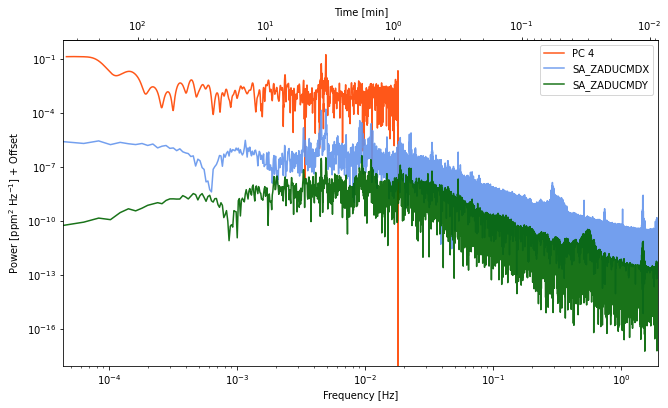

In [5]:
freq_pc, power_pc, max_pc = find_PSD(tim, pc4)
freq_sax, power_sax, max_sax = find_PSD(tim_sax, val_sax)
freq_say, power_say, max_say = find_PSD(tim_say, val_say)

print('>>> --- For PC 4: maximum power at {:.4f}'.format(max_pc))
print('>>> --- For SA_ZADUCMDX: maximum power at {:.4f}'.format(max_sax))
print('>>> --- For SA_ZADUCMDY: maximum power at {:.4f}'.format(max_say))

# Making the plot:
fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))

axs.plot(freq_pc.value, power_pc.value, color='orangered', alpha=0.9, label='PC 4')
axs.plot(freq_sax.value, power_sax.value/1000, color='cornflowerblue', alpha=0.9, label='SA_ZADUCMDX')
axs.plot(freq_say.value, power_say.value/100000, color='darkgreen', alpha=0.9, label='SA_ZADUCMDY')
#axs.axvline(freq1.value, ls='--', c='darkgreen')
axs.set_xscale('log')
axs.set_yscale('log')

axs.legend(loc='best')

axs.set_xlabel(r'Frequency [Hz]')
axs.set_ylabel(r'Power [ppm$^2$ Hz$^{-1}$] + Offset')
#axs.set_title('PSD of the PCA component' + str(nComp) + ' (Visit ' + visit[-1] + ')')

secax = axs.secondary_xaxis('top', functions=(freq2min, min2freq))
secax.set_xlabel(r'Time [min]')

axs.set_xlim([np.min(freq_sax.value), np.max(freq_sax.value)])

plt.savefig(p1 + '/Telemetry/Figures/PSDs_' + visit + '.png', dpi=500, facecolor='white')

Awesome!! Each frequencies (and PSDs) more-or-less matches with each other!

So, now we know that the high-frequency sinusoidal noise is coming from change of "ADU Commanded FSM Angle (on the sky) - X axis" (and from the Y-axis component at some extent). However, I don't really know what this exactly means in practice.

As I understand it, these are the X- and Y-axis components of the Fine Steering Mirror, we can see how "pointing" (this may not be a good word) is behaving on the sky.

Text(0.5, 0, 'SA_ZADUCMDY')

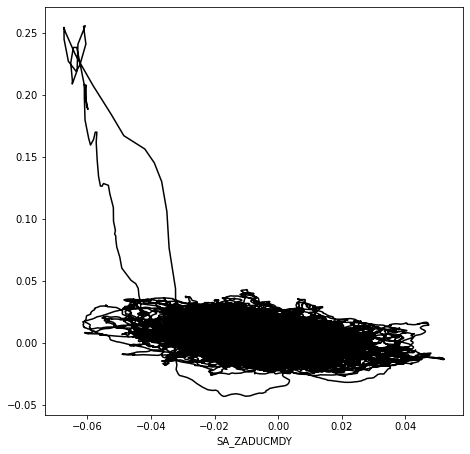

In [6]:
fig, axs = plt.subplots(figsize=(7.5, 7.5))

axs.plot(val_sax[tim_sax > tim[0]], val_say[tim_say > tim[0]], 'k-')
axs.set_xlabel('SA_ZADUCMDX')
axs.set_xlabel('SA_ZADUCMDY')

This is just looking like a noise, but apparently there is some structure in it.